In [1]:
import xarray as xr
from awips.dataaccess import DataAccessLayer
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta, timezone
from dynamicserialize.dstypes.com.raytheon.uf.common.time import TimeRange
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from sklearn.metrics import mean_squared_error
import cartopy.feature as cfeature
import xesmf as xe
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
from pyproj import Proj
from scipy.interpolate import griddata, RectBivariateSpline
from shapely.geometry import Polygon

In [2]:
initial_time = datetime.today().replace(day=5).astimezone(timezone.utc)

window_end = initial_time + timedelta(hours=2)

# Initialize DataAccessLayer to access EDEX server
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")

# CONUS bounding box and envelope geometry
bbox=[-130, -60, 20, 55]
envelope = Polygon([(bbox[0],bbox[2]),(bbox[0],bbox[3]),
                    (bbox[1], bbox[3]),(bbox[1],bbox[2]),
                    (bbox[0],bbox[2])])

In [3]:
def ncep_rap_fetch(start_time):
    # ncep_rap dataset URL from THREDDS
    ncep_rap_catalog_url = "https://thredds.ucar.edu/thredds/catalog/grib/NCEP/RAP/CONUS_13km/TwoD"
    # Fetch the most recent ncep_rap dataset
    cat = TDSCatalog(ncep_rap_catalog_url)
    dataset = list(cat.datasets.values())[0]
    # Access the ncep_rap subset using NCSS
    ncss = NCSS(dataset.access_urls['NetcdfSubset'])
    # Define the query for temperature data
    query = ncss.query().lonlat_box(bbox[0],bbox[1],bbox[2],bbox[3]).variables('Temperature_height_above_ground').time(start_time)
    # Retrieve the data
    return ncss.get_data(query)

def hrr_extract(ncep_rap_data):
    # Extract temperature and coordinates from the ncep_rap dataset
    # Convert kilometers to meters (PyProj expects meters)
    return (ncep_rap_data.variables['Temperature_height_above_ground'][:][0][0][0], 
            ncep_rap_data.variables['x'][:] * 1000,  # Convert to meters, 
            ncep_rap_data.variables['y'][:] * 1000  # Convert to meters
    )

def projection(ncep_rap_data):
    geospatial_lon_min = ncep_rap_data.geospatial_lon_min
    geospatial_lon_max = ncep_rap_data.geospatial_lon_max
    geospatial_lat_min = ncep_rap_data.geospatial_lat_min
    geospatial_lat_max = ncep_rap_data.geospatial_lat_max

    ext = [
        geospatial_lon_min,
        geospatial_lon_max,
        geospatial_lat_min,
        geospatial_lat_max
    ]

    lamb_proj = list(ncep_rap_data.variables.values())[-1]

    latitude_of_projection_origin = lamb_proj.latitude_of_projection_origin
    longitude_of_central_meridian = lamb_proj.longitude_of_central_meridian
    standard_parallel = lamb_proj.standard_parallel

    lambert_conformal_crs = ccrs.LambertConformal(
        central_longitude=longitude_of_central_meridian,
        central_latitude=latitude_of_projection_origin,
        standard_parallels=[standard_parallel]
        )

    lambert_conformal_proj = Proj(
        proj="lcc", 
        lat_1=standard_parallel,   # First standard parallel
        lat_0=latitude_of_projection_origin,   # Central latitude (origin)
        lon_0=longitude_of_central_meridian, # Central longitude (origin)
    )

    return ext, lambert_conformal_crs, lambert_conformal_proj


def lambert_to_platcarree(temps, lons, lats, lambert_conformal):
    x_grid, y_grid = np.meshgrid(lons.data, lats.data)

    lon_grid, lat_grid = lambert_conformal(x_grid,y_grid, inverse=True)

    x = lon_grid.flatten()
    y = lat_grid.flatten()
    values = temps.data.flatten()
    points = np.array([x, y]).T

    # Define a regular lat/lon grid () to interpolate to
    target_lons = np.linspace(x.min(), x.max(), lons.data.shape[0])  # Regular longitude grid
    target_lats = np.linspace(y.min(), y.max(), lats.data.shape[0])     # Regular latitude grid

    target_x_grid, target_y_grid = np.meshgrid(target_lons, target_lats)

    temperature_grid = griddata(points, values, (target_x_grid, target_y_grid), method='nearest') - 273.15

    # Create an xarray Dataset with the new grid
    return xr.Dataset(
        data_vars={
            'temperature': (['latitude', 'longitude'], temperature_grid)
        },
        coords={
            'longitude': (['longitude'], target_lons),
            'latitude': (['latitude'], target_lats)
        }
    )



ncep_rap_data = ncep_rap_fetch(initial_time)
t, x, y = hrr_extract(ncep_rap_data)
extent,lambert_crs,lambert_proj = projection(ncep_rap_data)
ncep_rap_dataset = lambert_to_platcarree(t,x,y,lambert_proj)

In [4]:

def fetch_metar_data(start, end):
    # Set up request for METAR data
    request = DataAccessLayer.newDataRequest("obs", envelope=envelope)
    params = ["temperature", "longitude", "latitude", "stationName"]
    request.setParameters(*(params))

    # Set the desired time for the request
    #request.setTimeRange(time)

    window = TimeRange(start,end)

    # Retrieve the METAR observations from the EDEX server
    response = DataAccessLayer.getGeometryData(request,window)
    obs = DataAccessLayer.getMetarObs(response)
    md = pd.DataFrame({
        "temperature": obs['temperature'],
        "longitude": obs['longitude'],
        "latitude": obs['latitude']
    })
    md_filtered = md[(md['temperature'] > -50) & (md['temperature'] < 60)]
    return md_filtered
'''
    lons, lats, temps = [], [], []
    
    # Extract latitude, longitude, and temperature from the observations
    for data in metar_data:
        if data.getNumber("temperature") is not None:
            #data.getLocationName()
            lons.append(data.getGeometry().x)
            lats.append(data.getGeometry().y)
            temps.append(data.getNumber("temperature"))


'''


# Fetch METAR data for the current time (use UTC)

metar_data = fetch_metar_data(initial_time,window_end)


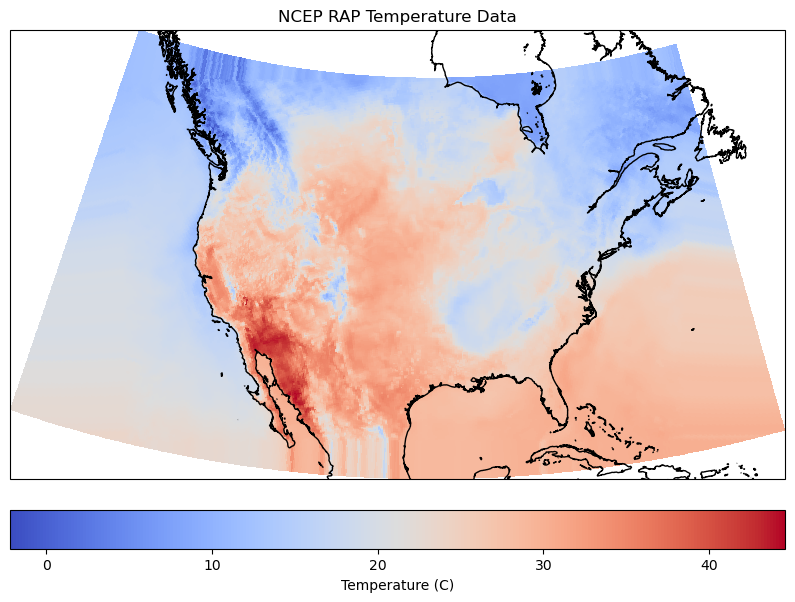

In [10]:
# Plot with Cartopy (Lambert Conformal projection)
plt.figure(figsize=(10, 8))
ax = plt.axes(projection = lambert_crs)

# Plot the temperature data using pcolormesh, with lat/lon
temp_plot = ax.pcolormesh(ncep_rap_dataset.longitude, ncep_rap_dataset.latitude, ncep_rap_dataset.temperature,
                           transform = ccrs.PlateCarree(), cmap='coolwarm')

# Add coastlines and states
ax.coastlines(resolution='10m')  # Coastlines at 10m resolution
#ax.add_feature(cfeature.BORDERS.with_scale('10m'))  # Country borders
#ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')  # US state borders

# Add colorbar
plt.colorbar(temp_plot, label="Temperature (C)", orientation="horizontal", pad=0.05)

# Set the extent (longitude and latitude range)

#ax.set_extent(extent)
# Title and display
plt.title("NCEP RAP Temperature Data")
plt.show()

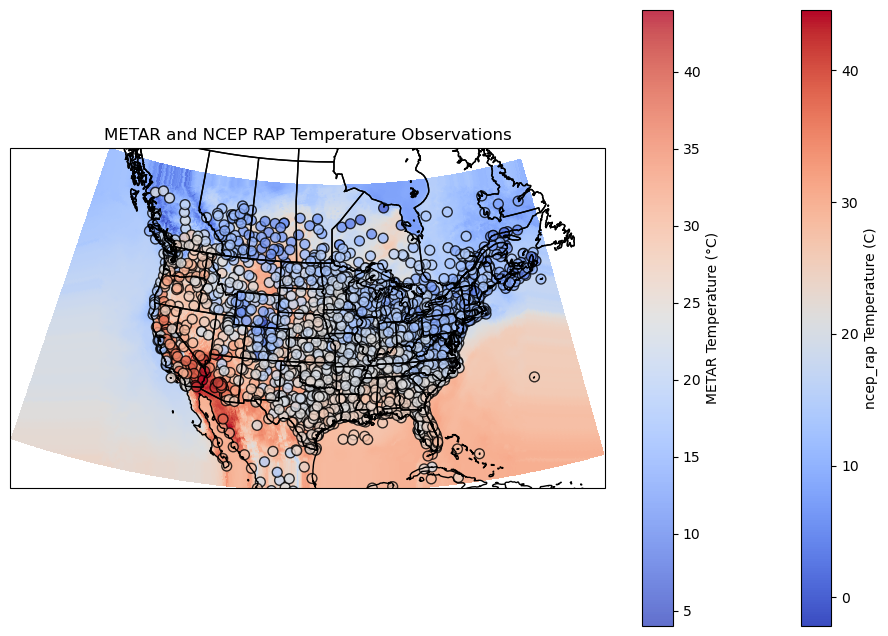

In [9]:
# Plotting the data on a map using Cartopy
def plot_data(metar_lons, metar_lats, metar_temps, ncep_rap_lons, ncep_rap_lats, ncep_rap_temps, crs_, ext):
    fig = plt.figure(figsize=(12, 8))
    ax = plt.axes(projection=crs_)
    
    # Set extent to cover the continental US
    ax.set_extent(ext, crs=ccrs.PlateCarree())
    
    # Add coastlines, borders, and state lines
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS)
    ax.add_feature(cfeature.STATES)

    # Plot ncep_rap temperature data (assumed to be on a grid)
    sc1 = ax.pcolormesh(ncep_rap_lons, ncep_rap_lats, ncep_rap_temps, cmap='coolwarm', transform=ccrs.PlateCarree(), alpha=1)
    plt.colorbar(sc1, ax=ax, orientation='vertical', label='ncep_rap Temperature (C)')
    
    # Plot METAR temperature observations
    sc2 = ax.scatter(metar_lons, metar_lats, c=metar_temps, cmap='coolwarm', s=50, edgecolor='k', transform=ccrs.PlateCarree(), alpha=0.8)
    plt.colorbar(sc2, ax=ax, orientation='vertical', label='METAR Temperature (°C)')

    plt.title(f'METAR and NCEP RAP Temperature Observations')
    plt.show()

# Plot both datasets together
plot_data(metar_data.longitude, metar_data.latitude, metar_data.temperature,
           ncep_rap_dataset.longitude, ncep_rap_dataset.latitude, ncep_rap_dataset.temperature,
           lambert_crs, extent)


In [7]:
def interpolate(x, y, values, target_lons, target_lats):

    points = np.array([x, y]).T

    # Define a regular lat/lon grid () to interpolate to
    target_x_grid, target_y_grid = np.meshgrid(target_lons, target_lats)

    temperature_grid = griddata(points, values, (target_x_grid, target_y_grid), method='nearest')
    print("error")
    # Create an xarray Dataset with the new grid
    return xr.Dataset(
        data_vars={
            'temperature': (['latitude', 'longitude'], temperature_grid)
        },
        coords={
            'longitude': (['longitude'], target_lons),
            'latitude': (['latitude'], target_lats)
        }
    )



# Interpolate the real observations to the ncep_rap grid
# longitude, latitude
lon_ncep_rap = ncep_rap_dataset.longitude.data
lat_ncep_rap = ncep_rap_dataset.latitude.data
#time_rap = rap_data.time.values

# Interpolating the real observations onto the ncep_rap grid (linear interpolation)
obs_on_ncep_rap_grid = interpolate(
    metar_data.longitude.values, metar_data.latitude.values, 
    metar_data.temperature.values, 
    lon_ncep_rap, lat_ncep_rap
)  

error


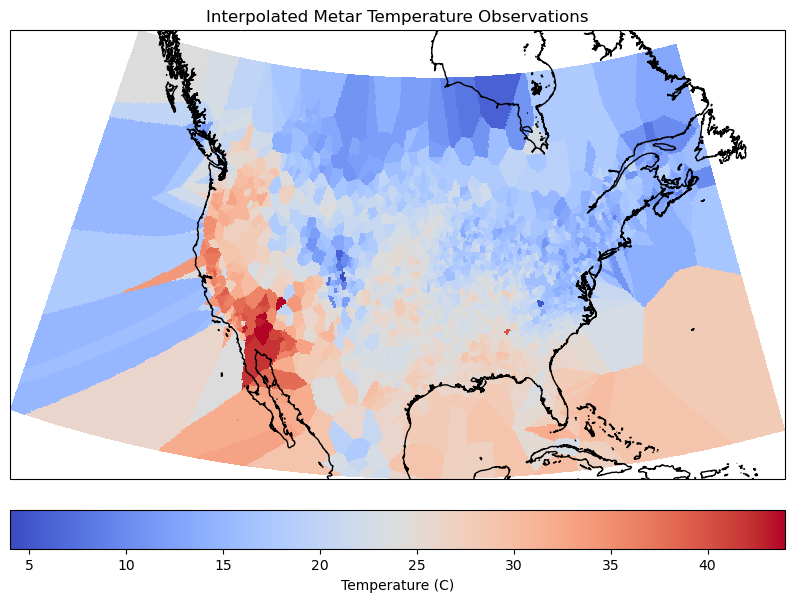

In [8]:
# Plot with Cartopy (Lambert Conformal projection)
plt.figure(figsize=(10, 8))
ax = plt.axes(projection = lambert_crs)

# Plot the temperature data using pcolormesh, with lat/lon
temp_plot = ax.pcolormesh(obs_on_ncep_rap_grid.longitude, obs_on_ncep_rap_grid.latitude, obs_on_ncep_rap_grid.temperature,
                           transform = ccrs.PlateCarree(), cmap='coolwarm')

# Add coastlines and states
ax.coastlines(resolution='10m')  # Coastlines at 10m resolution
#ax.add_feature(cfeature.BORDERS.with_scale('10m'))  # Country borders
#ax.add_feature(cfeature.STATES.with_scale('10m'), edgecolor='black')  # US state borders

# Add colorbar
plt.colorbar(temp_plot, label="Temperature (C)", orientation="horizontal", pad=0.05)

# Set the extent (longitude and latitude range)

#ax.set_extent(extent)
# Title and display
plt.title("Interpolated Metar Temperature Observations")
plt.show()